<img src="../logo_UTN.svg" align="right" width="200" /> 

# Tarea semanal 9
## Manuel Dieguez

# ¿Que vamos a estudiar en esta tarea?

El objetivo de esta tarea es disenar dos filtros IIR y dos filtros FIR para la senal de ECG y vamos a sacar conclusiones de cada filtrado

In [36]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io.wavfile import write
import warnings
warnings.filterwarnings('ignore')

In [9]:
def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

##################
# Lectura de ECG #
##################

fs_ecg = 1000 # Frecuencia de muestreo del ECG en Hz
N = 40000     # Muestras a tomar del ECG
t = np.arange(0, N/fs_ecg, 1/fs_ecg)
#w = 10

# para listar las variables que hay en el archivo

mat_struct = sio.loadmat('./ECG_TP4.mat')

#ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
ecg_one_lead = mat_struct['ecg_lead'].flatten()
qrs_detections = mat_struct['qrs_detections'].flatten()
ecg_one_lead_cut = ecg_one_lead[0:N]

t_full = np.arange(0,len(ecg_one_lead)/fs_ecg, 1/fs_ecg)

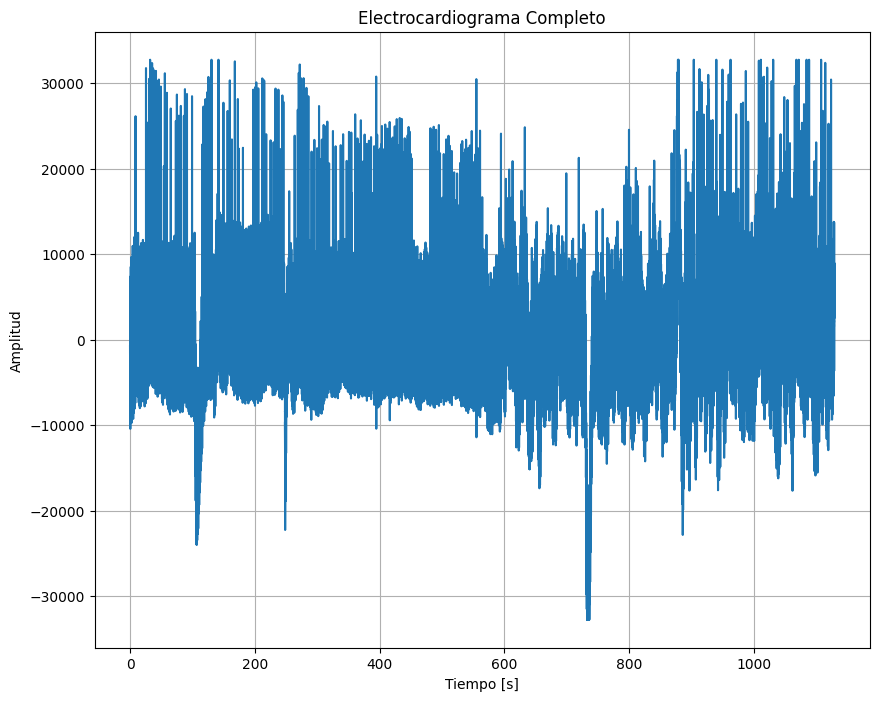

In [4]:
plt.figure(1, figsize=(10,8))
plt.title("Electrocardiograma Completo")
plt.ylabel("Amplitud")
plt.xlabel("Tiempo [s]")
plt.plot(t_full,ecg_one_lead)
#plt.plot(np.arange(0,N/fs_ecg,1/fs_ecg), ecg_one_lead_cut)
plt.grid()


Ahora vamos a mostrar el periodograma de la senal completa, luego de la senal recortada en sus primeros 40 segundos y por ultimo un Welch de la senal tomando ventanas de la senal recortada

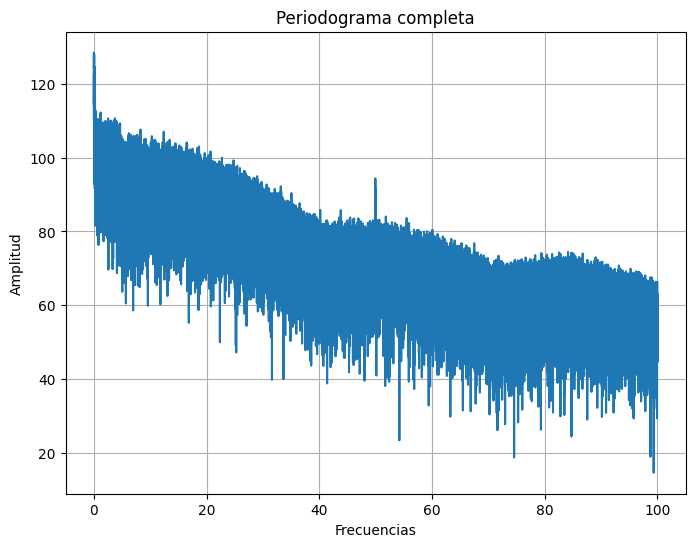

In [14]:
## Peridograma simple de la senal completa
freqs_full = np.fft.fftfreq(len(ecg_one_lead), d=1/fs_ecg)
fft_ecg_full = np.fft.fft(ecg_one_lead)
Pxx_ecg_full = np.abs(fft_ecg_full)**2/N
i = int(len(freqs_full)/2)
bool_index = (freqs_full >= 0) & (freqs_full <= 100)

plt.figure(2, figsize=(8,6))
plt.title("Periodograma completa")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_full[bool_index],10*np.log10(Pxx_ecg_full)[bool_index])
plt.grid()
plt.show()


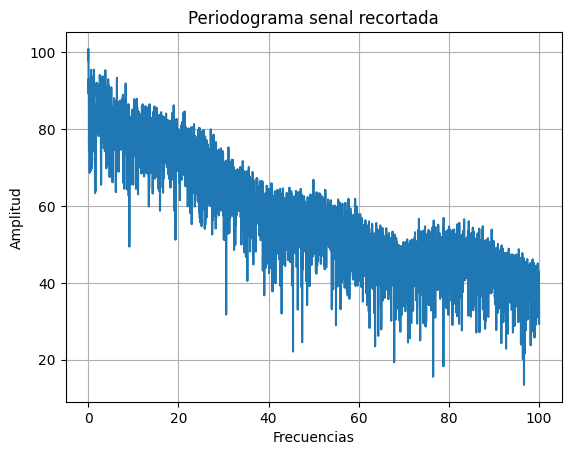

In [15]:
## Peridograma de la senal recortada
freqs = np.fft.fftfreq(N, d=1/fs_ecg)
fft_ecg = np.fft.fft(ecg_one_lead_cut)
Pxx_ecg = np.abs(fft_ecg)**2/N
#i = int(len(freqs)/2)
bool_index = (freqs >= 0) & (freqs <= 100)

plt.figure(3)
plt.title("Periodograma senal recortada")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs[bool_index],10*np.log10(Pxx_ecg)[bool_index])
plt.grid()
plt.show()


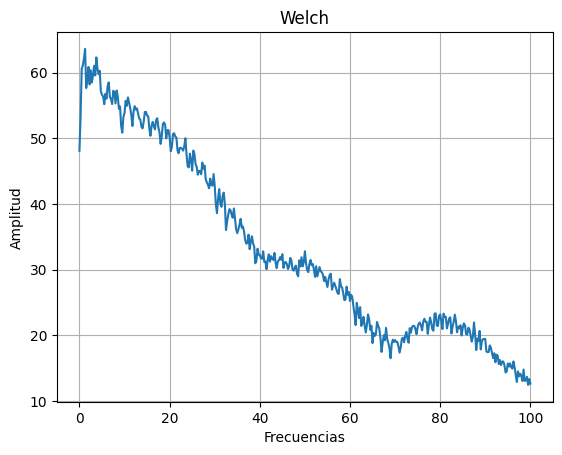

Vamos viendo como va mejorando la resolucion en amplitud, esto ya lo analizamos en tareas anteriores y vamos a usar la plantilla que obtuvimos en las mismas


In [17]:
## Hacemos la estimacion de Welch para las primeras N muestras del ECG
w = 10
[freqs_welch, fft_welch] = sc.signal.welch(ecg_one_lead_cut, fs_ecg, window = "hann", nperseg = int(N/w), detrend ="linear") ## Detrend saca la pendiente
bool_index = (freqs_welch >= 0) & (freqs_welch <= 100)

plt.figure(4)
plt.title("Welch")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_welch[bool_index],10*np.log10(fft_welch)[bool_index])
plt.grid()
plt.show()
print("Vamos viendo como va mejorando la resolucion en amplitud, esto ya lo analizamos en tareas anteriores y vamos a usar la plantilla que obtuvimos en las mismas")

Recordando nuestra plantilla:

- ripple = 0.5
- atenuacion = 40
- frecuencia de corte inferior = 0.5
- frecuencia de corte superior = 30
- frecuencia de rechazo inferior = 0.1
- frecuencia de rechazo superior = 45

## Filtrado IIR

El primer metodo que vamos a usar es IIR SOS (Second-Order Sections) que consiste en descomponer el filtro en múltiples etapas de segundo orden. Este enfoque mejora la estabilidad y precisión numérica en implementaciones digitales, especialmente cuando se requiere un filtro de alto orden.

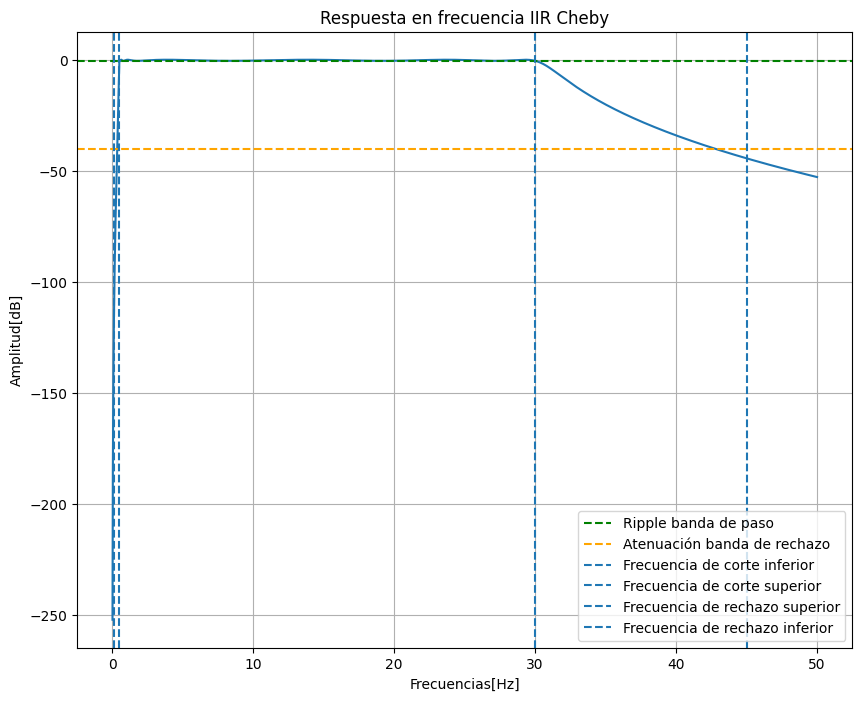

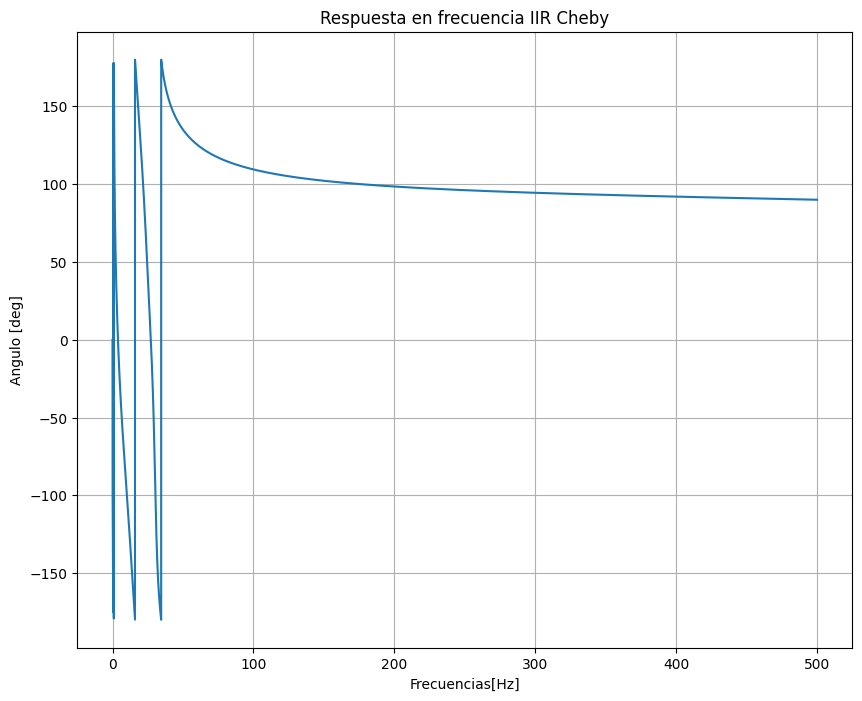

In [47]:
ripple = 0.5
att = 40

fci = 0.5
fcs = 30
fsi = 0.1
fss = 45

frecs = np.array([0, fsi, fci, fsi, fss, fs_ecg/2])/(fs_ecg/2)
gains = np.array([-att, -att, ripple, ripple, -att, -att])
gains = 10**(gains/20)


## Filtrado IIR SOS con Chebyshev

sos_iir_cheby = sc.signal.iirdesign([fci,fcs],[fsi,fss], ripple, att, ftype = 'cheby1', output = 'sos', fs = fs_ecg)
freqs_iir_cheby, iir_cheby_response = sc.signal.sosfreqz(sos_iir_cheby, worN = N)

index = (freqs_iir_cheby <= 2*np.pi*50/fs_ecg)
                                   
plt.figure(7,figsize=(10,8))
plt.title("Respuesta en frecuencia IIR Cheby")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Amplitud[dB]")
plt.plot(freqs_iir_cheby[index]/np.pi*(fs_ecg/2),20*np.log10(np.abs(iir_cheby_response[index])))
plt.axhline(-ripple, color='green', linestyle='--', label="Ripple banda de paso")
plt.axhline(-att, color='orange', linestyle='--', label="Atenuación banda de rechazo")
plt.axvline(fci,linestyle = '--', label = "Frecuencia de corte inferior")
plt.axvline(fcs,linestyle = '--', label = "Frecuencia de corte superior")
plt.axvline(fss,linestyle = '--', label = "Frecuencia de rechazo superior")
plt.axvline(fsi,linestyle = '--', label = "Frecuencia de rechazo inferior")
plt.legend()
plt.grid()
plt.show()

plt.figure(8, figsize=(10,8))
plt.title("Respuesta en frecuencia IIR Cheby")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Angulo [deg]")
plt.plot(freqs_iir_cheby/np.pi*(fs_ecg/2),np.angle((iir_cheby_response))*180/np.pi)
plt.grid()
plt.show()



Podemos ver que este diseno cumple con la plantilla, pero tiene un problema, su fase, la fase no lineal del filtro introduce retardo de grupo en la senal, deformando la senal resultante

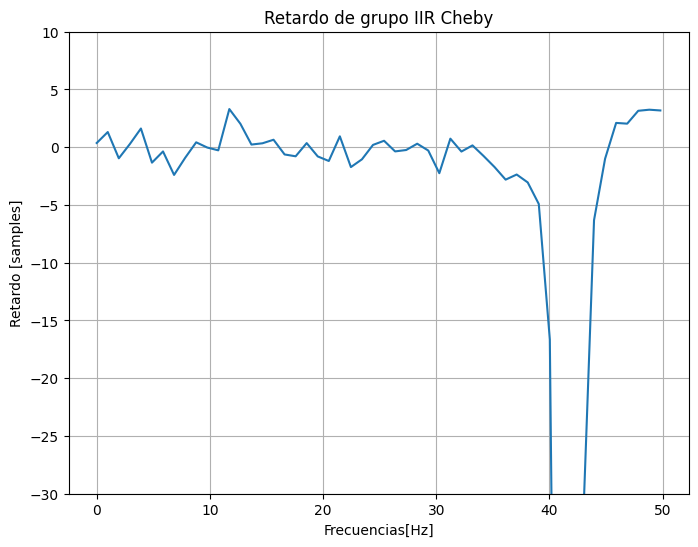

In [48]:
## Retardo de grupo
b,a = sc.signal.sos2tf(sos_iir_cheby)
freqs_delay, gd = sc.signal.group_delay((b,a), fs = fs_ecg)

plt.figure(9, figsize=(8,6))
plt.title("Retardo de grupo IIR Cheby")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Retardo [samples]")
plt.plot(freqs_delay[freqs_delay <=50],gd[freqs_delay <=50])
plt.ylim(-30,10)
plt.grid()
plt.show()

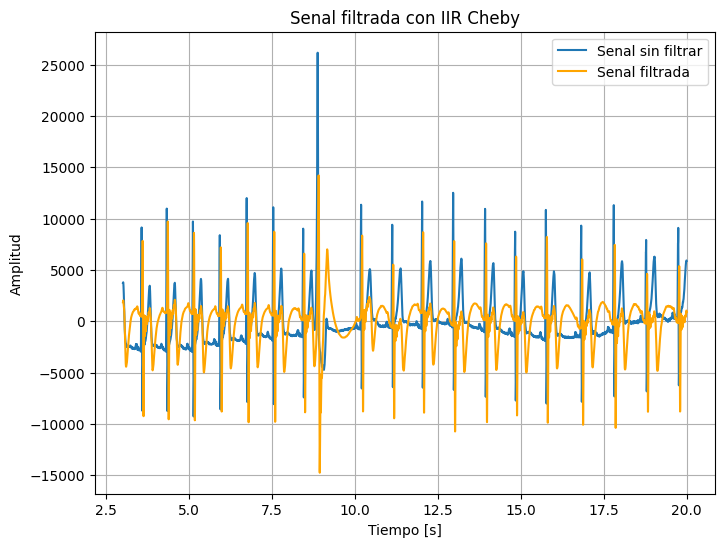

In [49]:
ecg_iir_cheby = sc.signal.sosfilt(sos_iir_cheby, ecg_one_lead)
zoom_region = np.arange(3000,20000)

plt.figure(10, figsize = (8,6))
plt.title("Senal filtrada con IIR Cheby")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.plot(t_full[zoom_region],ecg_one_lead[zoom_region], label = "Senal sin filtrar")
plt.plot(t_full[zoom_region],ecg_iir_cheby[zoom_region], label = "Senal filtrada", color="orange")
plt.legend()
plt.grid()
plt.show()

Podemos observar que mejorar la deriva en baja frecuencia, que el filtro actua segun lo esperado, pero para solucionar el problema del retardo de grupo, vamos a optar por un filtro IIR bidireccional, para esto se convolucionan dos filtros, cada uno con la mitad de atenuacion(menos exigente) y mitad de ripple(mas exigente) pero de fase complementaria, para convolucionarlos y obtener un filtro de fase 0 para toda frecuencia


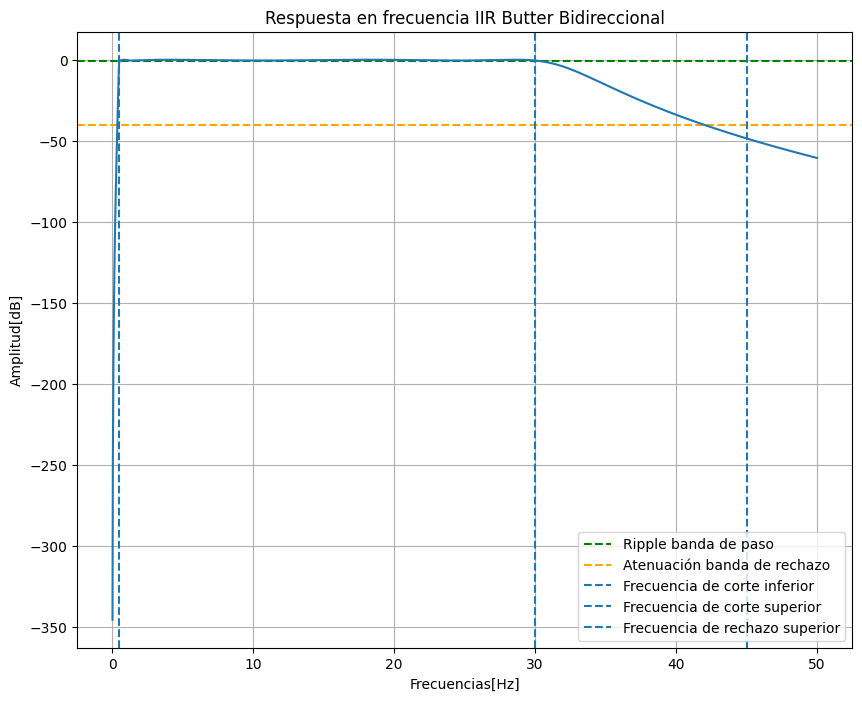

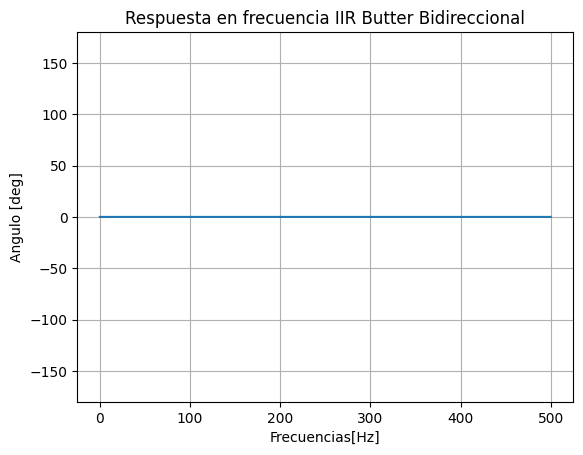

In [58]:
## Probamos un butter bidireccional

sos_iir_butter = sc.signal.iirdesign([fci,fcs],[fsi,fss], ripple/2, att/2, ftype = 'cheby1', output = 'sos', fs = fs_ecg)
freqs_iir_butter, iir_butter_response = sc.signal.sosfreqz(sos_iir_butter, worN = N)

## Genero una respuesta al impulso para filtrar bidireccionalmente

h_butter_bidir = np.multiply(iir_butter_response, np.conj(iir_butter_response))
index = (freqs_iir_butter <= 2*np.pi*50/fs_ecg)

plt.figure(10, figsize =(10,8))
plt.title("Respuesta en frecuencia IIR Butter Bidireccional")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Amplitud[dB]")
plt.axhline(-ripple, color='green', linestyle='--', label="Ripple banda de paso")
plt.axhline(-att, color='orange', linestyle='--', label="Atenuación banda de rechazo")
plt.axvline(fci,linestyle = '--', label = "Frecuencia de corte inferior")
plt.axvline(fcs,linestyle = '--', label = "Frecuencia de corte superior")
plt.axvline(fss,linestyle = '--', label = "Frecuencia de rechazo superior")
#plt.axvline(fsi,linestyle = '--', label = "Frecuencia de rechazo inferior")
plt.plot(freqs_iir_butter[index]/np.pi*(fs_ecg/2),20*np.log10(np.abs(h_butter_bidir[index])))
plt.legend()
plt.grid()
plt.show()

plt.figure(11)
plt.title("Respuesta en frecuencia IIR Butter Bidireccional")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Angulo [deg]")
plt.ylim(-180, 180)
plt.plot(freqs_iir_butter/np.pi*(fs_ecg/2),np.angle((h_butter_bidir))*180/np.pi)
plt.grid()
plt.show()



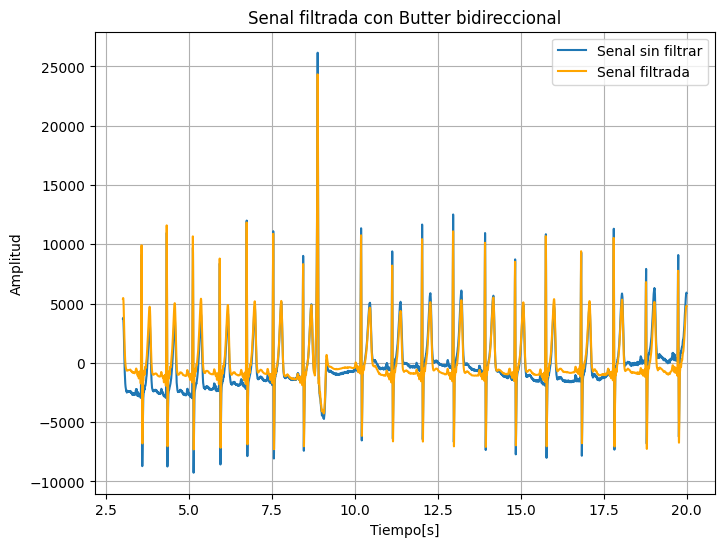

In [56]:
ecg_filt_butter_bid = sc.signal.sosfiltfilt(sos_iir_butter, ecg_one_lead)

plt.figure(12, figsize = (8,6))
plt.title("Senal filtrada con Butter bidireccional")
plt.xlabel("Tiempo[s]")
plt.ylabel("Amplitud")
plt.plot(t_full[zoom_region],ecg_one_lead[zoom_region], label = "Senal sin filtrar")
plt.plot(t_full[zoom_region],ecg_filt_butter_bid[zoom_region], label = "Senal filtrada", color="orange")
plt.legend()
plt.grid()
plt.show()


Podemos observar que este filtro no mete demora en la respuesta, y disminuye la deriva en baja frecuencia y el ruido en alta, lo consideramos una mejor opcion que el filtro sos anterior

## Filtrado FIR

Vamos ahora a disenar dos filtros FIR, la ventaja de estos filtros es que no suelen introducir retardo de grupo, aunque requieren de mayor orden. Tambien son estables.

Primero vamos a utilizar el método de cuadrados minimos.  El método de cuadrados mínimos para el diseño de filtros FIR busca minimizar el error cuadrático entre la respuesta deseada del filtro y su respuesta real en frecuencia.

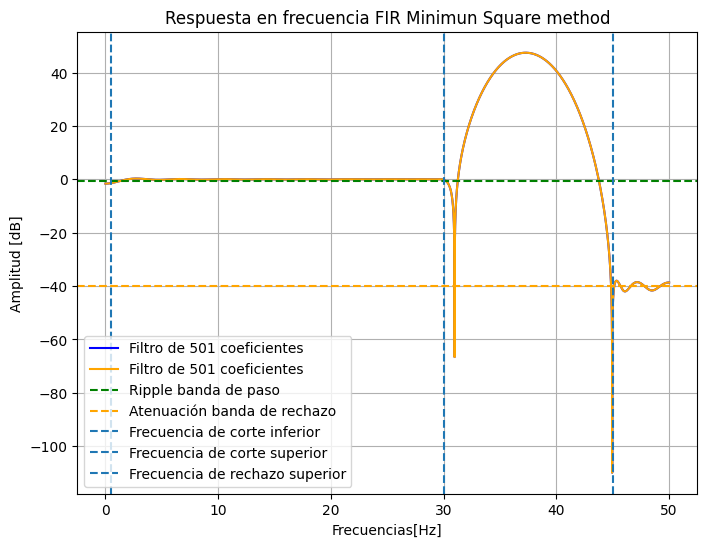

In [109]:
## Filtrado FIR

## Probamos metodo de cuad minimos

cant_coeff = 501
demora = int((cant_coeff-1)/2)
att_veces = 10**(-att/20)
ripple_veces = 10**(-ripple/20)

bands = np.array([0, fsi, fci, fcs, fss, fs_ecg/2])
desired = (att_veces, att_veces, 1, 1, att_veces, att_veces)

coeff_firls = sc.signal.firls(cant_coeff, bands, desired, fs = fs_ecg)
freqs_fir_lse, fir_lse = sc.signal.freqz(coeff_firls, a=1, worN = 2**20, fs = fs_ecg)

coeff_firls_501 = sc.signal.firls(501, bands, desired, fs = fs_ecg)
freqs_fir_lse_501, fir_lse_501 = sc.signal.freqz(coeff_firls_501, a=1, worN = 2**20, fs = fs_ecg)
 
plt.figure(13, figsize =(8,6))
plt.title("Respuesta en frecuencia FIR Minimun Square method")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Amplitud [dB]")
plt.plot(freqs_fir_lse[freqs_fir_lse <= 50], 20*np.log10(np.abs(fir_lse[freqs_fir_lse <= 50])), \
         label = "Filtro de 501 coeficientes", color = "blue")
plt.plot(freqs_fir_lse_501[freqs_fir_lse_501 <= 50], 20*np.log10(np.abs(fir_lse_501[freqs_fir_lse_501 <= 50])), \
         label = "Filtro de 501 coeficientes", color = "orange")
plt.axhline(-ripple, color='green', linestyle='--', label="Ripple banda de paso")
plt.axhline(-att, color='orange', linestyle='--', label="Atenuación banda de rechazo")
plt.axvline(fci,linestyle = '--', label = "Frecuencia de corte inferior")
plt.axvline(fcs,linestyle = '--', label = "Frecuencia de corte superior")
plt.axvline(fss,linestyle = '--', label = "Frecuencia de rechazo superior")
plt.legend()
plt.grid()
plt.show()

#plt.figure(14, figsize =(8,6))
#plt.title("Respuesta en frecuencia FIR Minimun Square method")
#plt.xlabel("Frecuencias[Hz]")
#plt.ylabel("Angulo [deg]")
#plt.plot(freqs_fir_lse, np.angle(fir_lse)*180/np.pi ) 
#plt.grid()
#plt.show()

Podemos ver que el filtro no cumple con la plantilla, y si aumentamos la cantidad de coeficientes se empieza a generar un lobulo en la banda de paso. Vamos a buscar solucionarlo implementado un filtro pasabajo y otro pasaalto para luego convolucionar

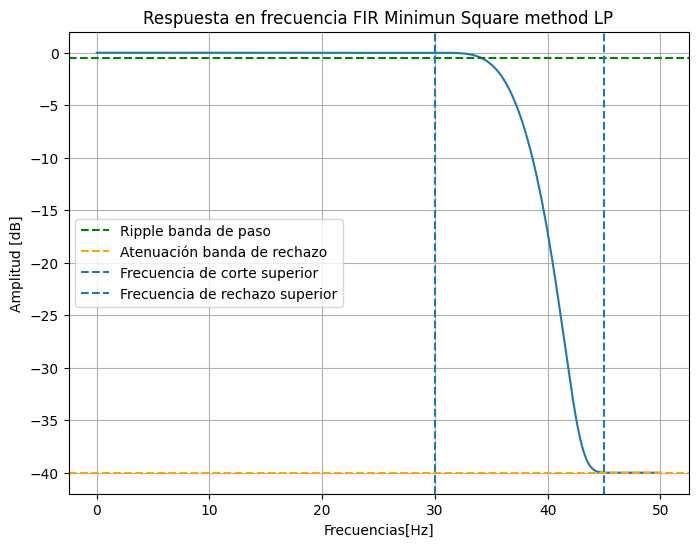

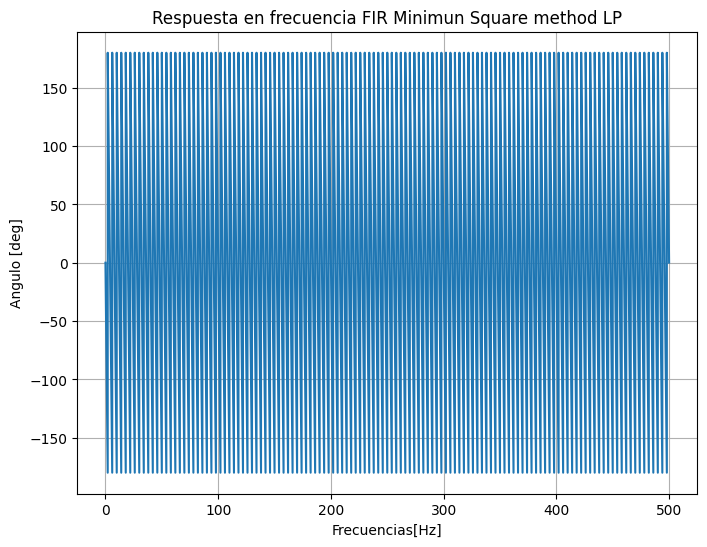

In [127]:
## Pasabajo

order_lp = 500
bands_lp = np.array([0, fcs, fss, fs_ecg/2])
gains_lp = np.array([1, 1, att_veces, att_veces])

coeff_firls_lp = sc.signal.firls(order_lp+1, bands_lp, gains_lp, fs = fs_ecg)
freqs_fir_lse_lp, fir_lse_lp = sc.signal.freqz(coeff_firls_lp, a=1, worN = 2**20, fs = fs_ecg)

plt.figure(15, figsize =(8,6))
plt.title("Respuesta en frecuencia FIR Minimun Square method LP")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Amplitud [dB]")
plt.plot(freqs_fir_lse_lp[freqs_fir_lse_lp <= 50], 20*np.log10(np.abs(fir_lse_lp[freqs_fir_lse_lp <= 50])))
plt.axhline(-ripple, color='green', linestyle='--', label="Ripple banda de paso")
plt.axhline(-att, color='orange', linestyle='--', label="Atenuación banda de rechazo")
plt.axvline(fcs,linestyle = '--', label = "Frecuencia de corte superior")
plt.axvline(fss,linestyle = '--', label = "Frecuencia de rechazo superior")
plt.legend()
plt.grid()
plt.show()

plt.figure(16, figsize=(8,6))
plt.title("Respuesta en frecuencia FIR Minimun Square method LP")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Angulo [deg]")
plt.plot(freqs_fir_lse_lp, np.angle(fir_lse_lp)*180/np.pi ) 
plt.grid()
plt.show()



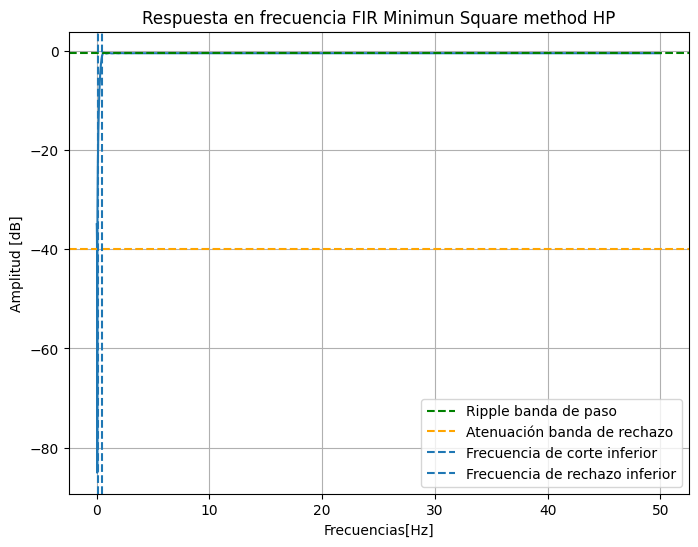

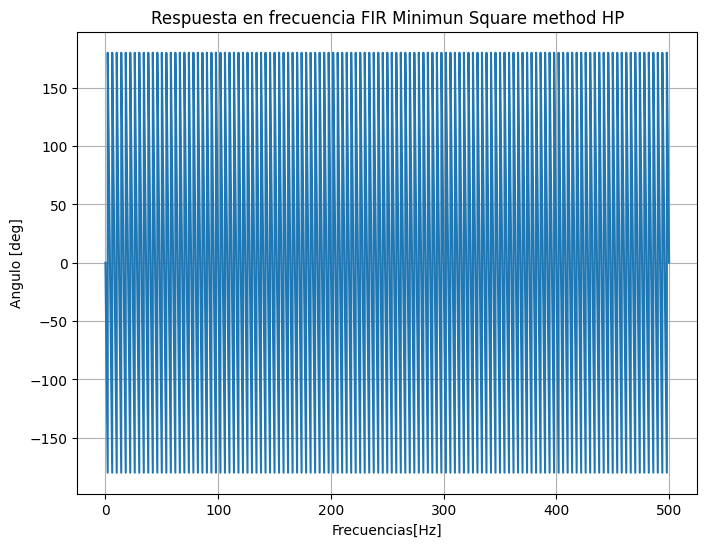

In [138]:
## Pasa Altos

order_hp = 3500
bands_hp = np.array([0, fsi, fci, fs_ecg/2])
gains_hp = np.array([att_veces, att_veces, ripple_veces, ripple_veces])

coeff_firls_hp = sc.signal.firls(order_hp + 1, bands_hp, gains_hp, fs = fs_ecg)
freqs_fir_lse_hp, fir_lse_hp = sc.signal.freqz(coeff_firls_hp, a=1, worN = 2**20, fs = fs_ecg)

plt.figure(17, figsize =(8,6))
plt.title("Respuesta en frecuencia FIR Minimun Square method HP")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Amplitud [dB]")
plt.plot(freqs_fir_lse_hp[freqs_fir_lse_hp <= 50], 20*np.log10(np.abs(fir_lse_hp[freqs_fir_lse_hp <= 50])))
plt.axhline(-ripple, color='green', linestyle='--', label="Ripple banda de paso")
plt.axhline(-att, color='orange', linestyle='--', label="Atenuación banda de rechazo")
plt.axvline(fci,linestyle = '--', label = "Frecuencia de corte inferior")
plt.axvline(fsi,linestyle = '--', label = "Frecuencia de rechazo inferior")
plt.legend()
plt.grid()
plt.show()


plt.figure(18, figsize= (8,6))
plt.title("Respuesta en frecuencia FIR Minimun Square method HP")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Angulo [deg]")
plt.plot(freqs_fir_lse_lp, np.angle(fir_lse_lp)*180/np.pi ) 
plt.grid()
plt.show()

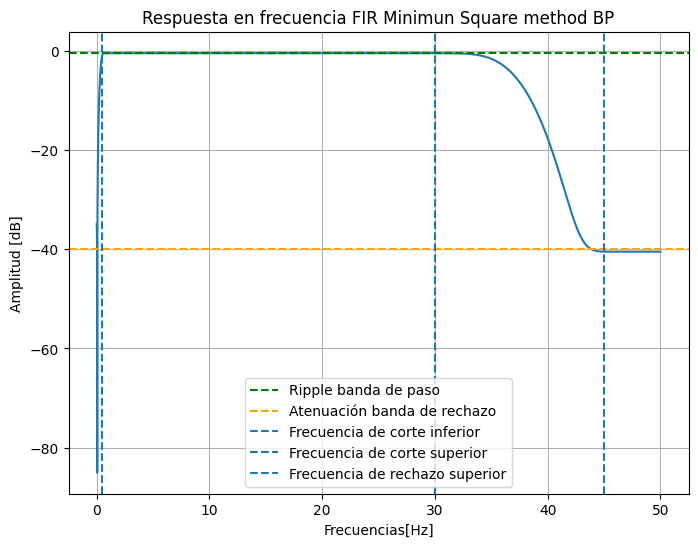

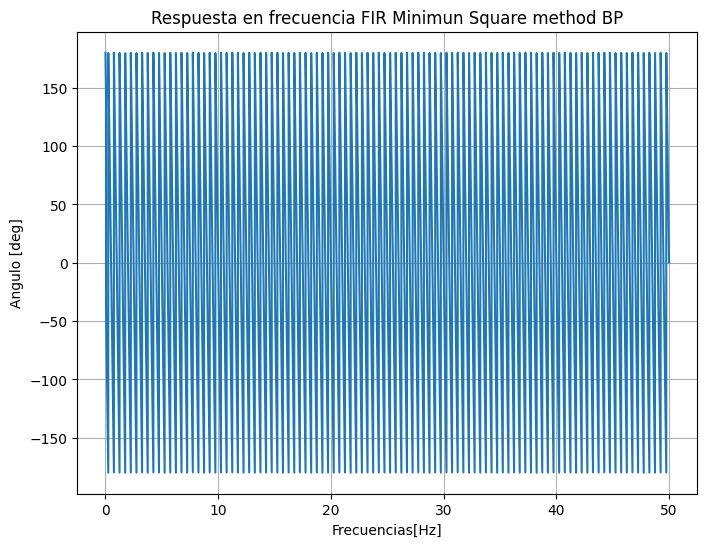

In [142]:
## Convolucionamos ambos filtros

coeff_firls_bp = np.convolve(coeff_firls_lp,coeff_firls_hp)
freqs_fir_lse_bp, fir_lse_bp = sc.signal.freqz(coeff_firls_bp, a=1, worN = 2**20, fs = fs_ecg)

plt.figure(19, figsize =(8,6))
plt.title("Respuesta en frecuencia FIR Minimun Square method BP")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Amplitud [dB]")
plt.plot(freqs_fir_lse_bp[freqs_fir_lse_bp <= 50], 20*np.log10(np.abs(fir_lse_bp[freqs_fir_lse_bp <= 50])))
plt.axhline(-ripple, color='green', linestyle='--', label="Ripple banda de paso")
plt.axhline(-att, color='orange', linestyle='--', label="Atenuación banda de rechazo")
plt.axvline(fci,linestyle = '--', label = "Frecuencia de corte inferior")
#plt.axvline(fsi,linestyle = '--', label = "Frecuencia de rechazo inferior")
plt.axvline(fcs,linestyle = '--', label = "Frecuencia de corte superior")
plt.axvline(fss,linestyle = '--', label = "Frecuencia de rechazo superior")
plt.legend()
plt.legend()
plt.grid()
plt.show()


plt.figure(20, figsize= (8,6))
plt.title("Respuesta en frecuencia FIR Minimun Square method BP")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Angulo [deg]")
plt.plot(freqs_fir_lse_bp[freqs_fir_lse_bp <= 50], np.angle(fir_lse_bp[freqs_fir_lse_bp <= 50])*180/np.pi ) 
plt.grid()
plt.show()

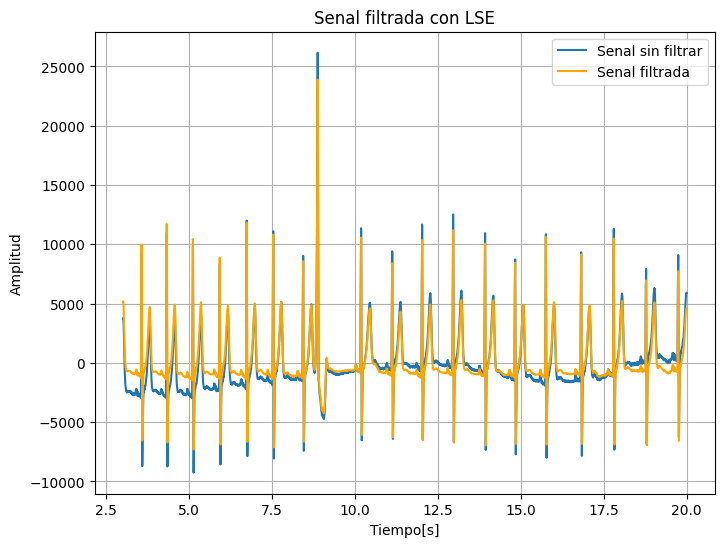

In [151]:
ecg_filt_firls = sc.signal.lfilter(coeff_firls_bp, 1, ecg_one_lead)
demora_lse = int((len(coeff_firls_bp)-1)/2)

plt.figure(12, figsize = (8,6))
plt.title("Senal filtrada con LSE")
plt.xlabel("Tiempo[s]")
plt.ylabel("Amplitud")
plt.plot(t_full[zoom_region],ecg_one_lead[zoom_region], label = "Senal sin filtrar")
plt.plot(t_full[zoom_region],ecg_filt_firls[zoom_region+demora_lse], label = "Senal filtrada", color="orange")
plt.legend()
plt.grid()
plt.show()

In [155]:
print(f"De esta forma, convolucionando ambos filtros pudimos conseguir una buena atenuacion en las bandas de rechazo, \
pero a costa de una demora mucho mayor, aunque si no queremos procesar en tiempo real, una demora de {demora_lse/fs_ecg:.2f} \
segundos no es una preocupacion")

De esta forma, convolucionando ambos filtros pudimos conseguir una buena atenuacion en las bandas de rechazo, pero a costa de una demora mucho mayor, aunque si no queremos procesar en tiempo real, una demora de 2.00 segundos no es una preocupacion


Ahora vamos a probar con un filtro FIR por ventana, que es un tipo de filtro digital en el que los coeficientes del filtro se diseñan aplicando una ventana a la respuesta ideal de un filtro

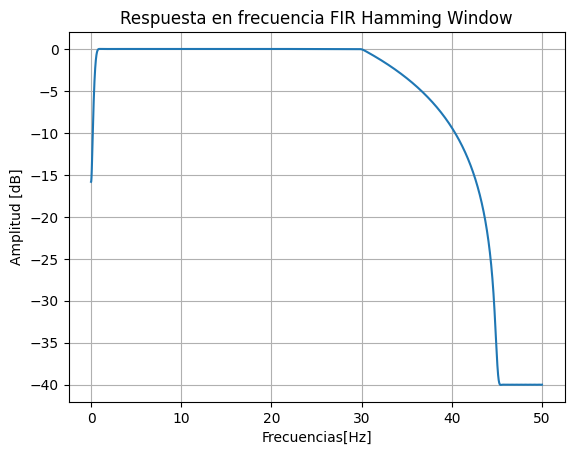

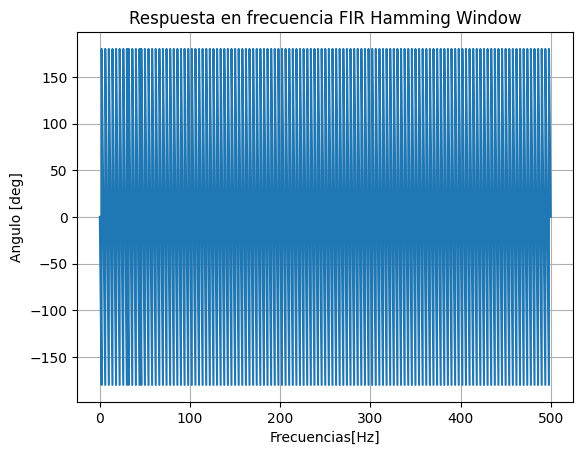

In [161]:
cant_coeff_win = 4001
demora_win = int((cant_coeff_win-1)/2)

coeff_firwin = sc.signal.firwin2(cant_coeff_win, bands/(fs_ecg/2), desired, nfreqs=2**16 , window = "hamming")
freqs_fir_win, fir_win = sc.signal.freqz(coeff_firwin, a=1, worN = 2**20, fs = fs_ecg)

plt.figure(21)
plt.title("Respuesta en frecuencia FIR Hamming Window")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Amplitud [dB]")
plt.plot(freqs_fir_win[freqs_fir_win <= 50], 20*np.log10(np.abs(fir_win[freqs_fir_win <= 50])) ) 
plt.grid()
plt.show()

plt.figure(22)
plt.title("Respuesta en frecuencia FIR Hamming Window")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Angulo [deg]")
plt.plot(freqs_fir_win, np.angle(fir_lse)*180/np.pi ) 
plt.grid()
plt.show()

Como no obtenemos la atenuacion requerida en la banda inferior, repetimos el metodo anterior

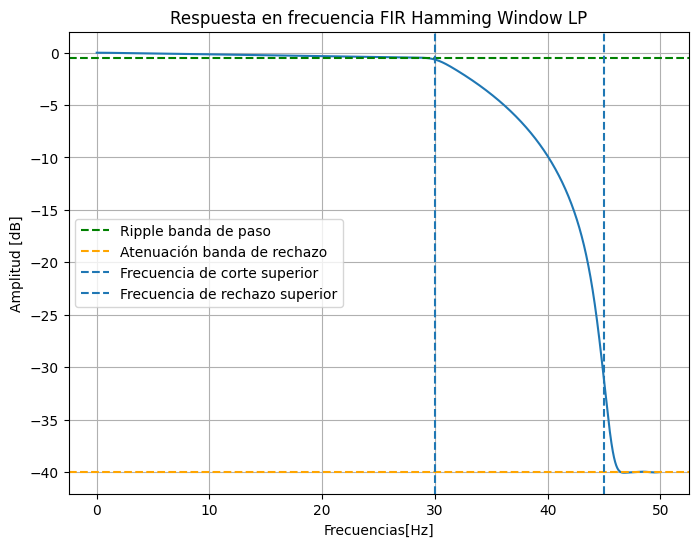

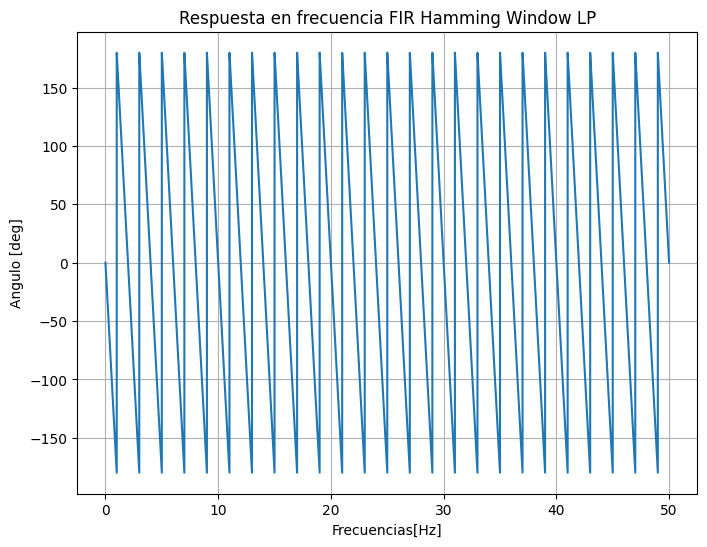

In [176]:
cant_coeff_win_lp = 1001

bands_lp = np.array([0, fcs, fss, fs_ecg/2])/(fs_ecg/2)
gains_lp = np.array([1, ripple_veces, att_veces, att_veces])

coeff_firwin_lp = sc.signal.firwin2(cant_coeff_win_lp, bands_lp, gains_lp, nfreqs=2**16 , window = "hamming")
freqs_fir_win_lp, fir_win_lp = sc.signal.freqz(coeff_firwin_lp, a=1, worN = 2**20, fs = fs_ecg)

plt.figure(23, figsize = (8,6))
plt.title("Respuesta en frecuencia FIR Hamming Window LP")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Amplitud [dB]")
plt.plot(freqs_fir_win_lp[freqs_fir_win_lp <= 50], 20*np.log10(np.abs(fir_win_lp[freqs_fir_win_lp <= 50])) ) 
plt.axhline(-ripple, color='green', linestyle='--', label="Ripple banda de paso")
plt.axhline(-att, color='orange', linestyle='--', label="Atenuación banda de rechazo")
plt.axvline(fcs,linestyle = '--', label = "Frecuencia de corte superior")
plt.axvline(fss,linestyle = '--', label = "Frecuencia de rechazo superior")
plt.legend()
plt.grid()
plt.show()

plt.figure(24, figsize = (8,6))
plt.title("Respuesta en frecuencia FIR Hamming Window LP")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Angulo [deg]")
plt.plot(freqs_fir_win_lp[freqs_fir_win_lp <= 50], np.angle(fir_win_lp[freqs_fir_win_lp <= 50])*180/np.pi ) 
plt.grid()
plt.show()

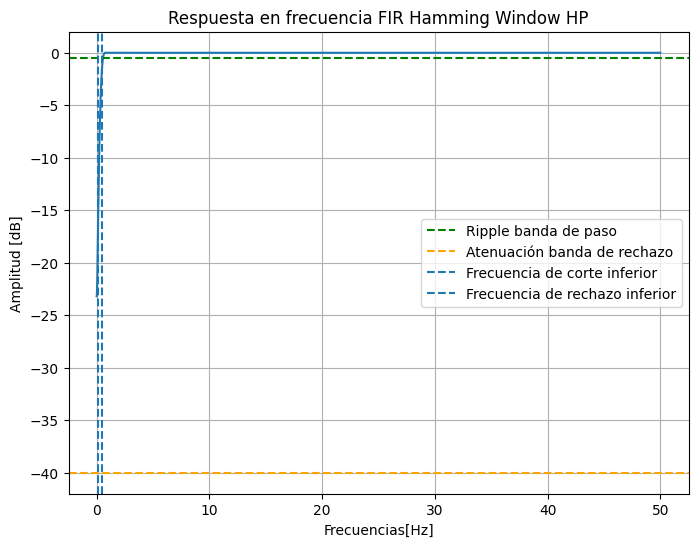

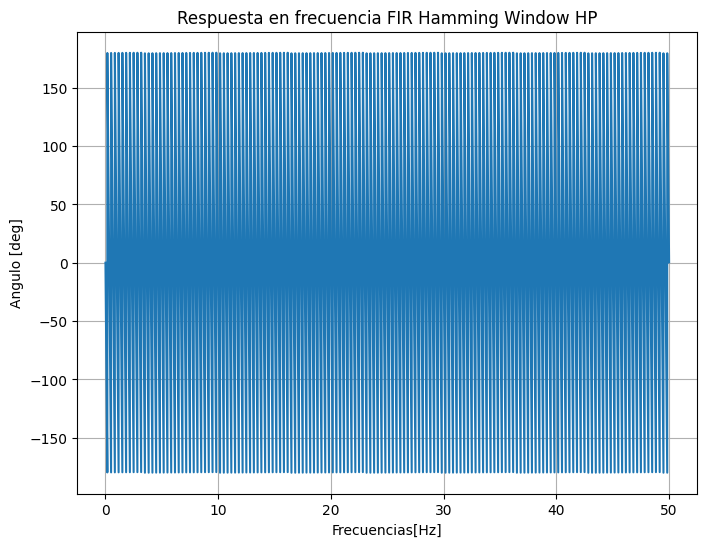

In [187]:
cant_coeff_win_hp = 6001

bands_hp = np.array([0, fsi, fci, fs_ecg/2])/(fs_ecg/2)
gains_hp = np.array([att_veces, att_veces, 1, 1])

coeff_firwin_hp = sc.signal.firwin2(cant_coeff_win_hp, bands_hp, gains_hp, nfreqs=2**16 , window = "hamming")
freqs_fir_win_hp, fir_win_hp = sc.signal.freqz(coeff_firwin_hp, a=1, worN = 2**20, fs = fs_ecg)

plt.figure(25, figsize = (8,6))
plt.title("Respuesta en frecuencia FIR Hamming Window HP")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Amplitud [dB]")
plt.plot(freqs_fir_win_hp[freqs_fir_win_hp <= 50], 20*np.log10(np.abs(fir_win_hp[freqs_fir_win_hp <= 50])) ) 
plt.axhline(-ripple, color='green', linestyle='--', label="Ripple banda de paso")
plt.axhline(-att, color='orange', linestyle='--', label="Atenuación banda de rechazo")
plt.axvline(fci,linestyle = '--', label = "Frecuencia de corte inferior")
plt.axvline(fsi,linestyle = '--', label = "Frecuencia de rechazo inferior")
plt.legend()
plt.grid()
plt.show()

plt.figure(26, figsize = (8,6))
plt.title("Respuesta en frecuencia FIR Hamming Window HP")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Angulo [deg]")
plt.plot(freqs_fir_win_hp[freqs_fir_win_hp <= 50], np.angle(fir_win_hp[freqs_fir_win_hp <= 50])*180/np.pi ) 
plt.grid()
plt.show()

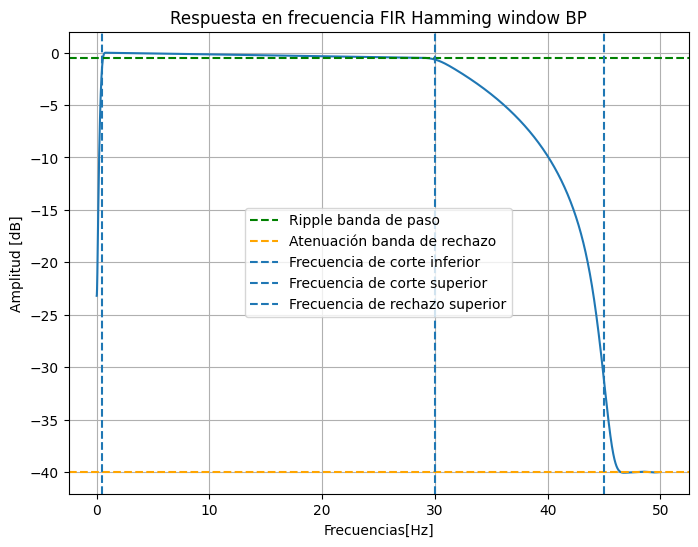

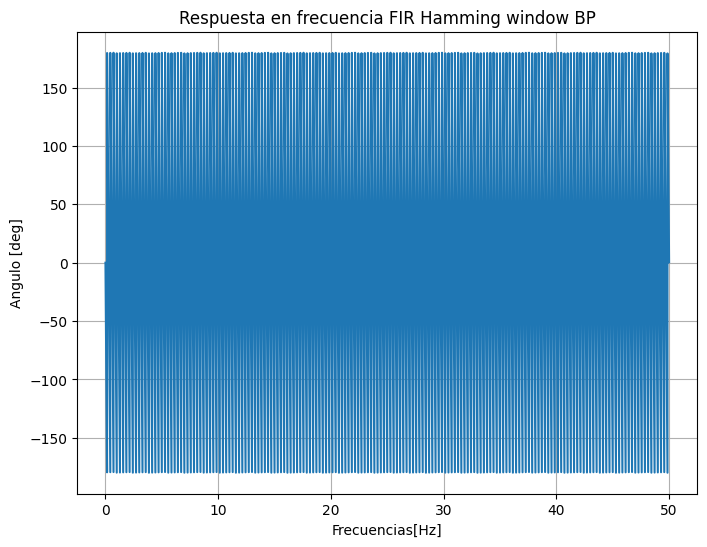

In [188]:
## Convolucionamos ambos filtros

coeff_firwin_bp = np.convolve(coeff_firwin_lp,coeff_firwin_hp)
freqs_fir_win_bp, fir_win_bp = sc.signal.freqz(coeff_firwin_bp, a=1, worN = 2**20, fs = fs_ecg)

plt.figure(27, figsize =(8,6))
plt.title("Respuesta en frecuencia FIR Hamming window BP")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Amplitud [dB]")
plt.plot(freqs_fir_win_bp[freqs_fir_win_bp <= 50], 20*np.log10(np.abs(fir_win_bp[freqs_fir_win_bp <= 50])))
plt.axhline(-ripple, color='green', linestyle='--', label="Ripple banda de paso")
plt.axhline(-att, color='orange', linestyle='--', label="Atenuación banda de rechazo")
plt.axvline(fci,linestyle = '--', label = "Frecuencia de corte inferior")
#plt.axvline(fsi,linestyle = '--', label = "Frecuencia de rechazo inferior")
plt.axvline(fcs,linestyle = '--', label = "Frecuencia de corte superior")
plt.axvline(fss,linestyle = '--', label = "Frecuencia de rechazo superior")
plt.legend()
plt.legend()
plt.grid()
plt.show()


plt.figure(28, figsize= (8,6))
plt.title("Respuesta en frecuencia FIR Hamming window BP")
plt.xlabel("Frecuencias[Hz]")
plt.ylabel("Angulo [deg]")
plt.plot(freqs_fir_win_bp[freqs_fir_win_bp <= 50], np.angle(fir_win_bp[freqs_fir_win_bp <= 50])*180/np.pi ) 
plt.grid()
plt.show()

Podemos observar que este metodo, si bien es mas sencillo, utiliza

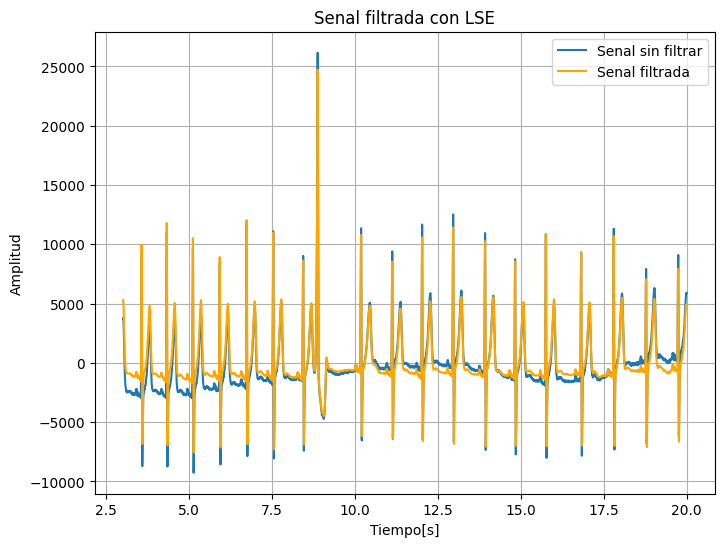

El filtro introduce una demora de 3.50 
Si bien este metodo es mas sencillo, no logramos la misma atenuacion que con el metodo de cuadrados minimos, utilizando mas coeficientes


In [195]:
ecg_filt_firwin = sc.signal.lfilter(coeff_firwin_bp, 1, ecg_one_lead)
demora_win = int((len(coeff_firwin_bp)-1)/2)

plt.figure(29, figsize = (8,6))
plt.title("Senal filtrada con LSE")
plt.xlabel("Tiempo[s]")
plt.ylabel("Amplitud")
plt.plot(t_full[zoom_region],ecg_one_lead[zoom_region], label = "Senal sin filtrar")
plt.plot(t_full[zoom_region],ecg_filt_firwin[zoom_region+demora_win], label = "Senal filtrada", color="orange")
plt.legend()
plt.grid()
plt.show()

print(f"El filtro introduce una demora de {demora_win/fs_ecg:.2f} \nSi bien este metodo es mas sencillo, no logramos la misma \
atenuacion que con el metodo de cuadrados minimos, utilizando mas coeficientes")

## Conclusion

En esta tarea, pudimos hacer un paneo entre diferentes métodos de filtrado, tanto FIR como IIR.

En resumen, podemos decir que los filtros FIR son más sencillos, estables por naturaleza y fácilmente diseñables para tener retardo de grupo constante, pero requieren una mayor cantidad de coeficientes y, por ende, más demora y cómputos.

Por otro lado, los IIR son más complejos, pero permiten obtener la plantilla deseada con menos coeficientes. Sin embargo, debemos tener en cuenta el retardo de grupo, siendo una solución a este el filtrado bidireccional, que anula la distorsión en fase del filtro.